# Refactored Notebook: NLP for Command Line Analysis

This notebook demonstrates a natural language processing (NLP) workflow to analyze command-line logs, identify patterns, and group similar commands using topic modeling with Latent Dirichlet Allocation (LDA).

### Key steps in this notebook:
1.  **Data Ingestion**: Load command-line data from Sysmon event logs.
2.  **Data Preprocessing**: Clean, normalize, and tokenize the command-line strings.
3.  **Feature Engineering**: Convert the text data into a numerical format using TF-IDF and apply feature scaling.
4.  **Model Training**: Tune hyperparameters and train an LDA model to discover topics in the command-line data.
5.  **Visualization**: Visualize the results using Plotly for interactive exploration and analysis.

# ⚡ OPTIMIZED VERSION - November 2025

This notebook has been updated with significant improvements:

### 🎯 Key Changes:
1. **Modular Architecture**: Core functionality moved to `main.py`, `config.py`, `data_loader.py`
2. **Multiple Data Sources**: Support for CSV, synthetic data, or ISF database
3. **No ISF Dependency**: Can run without proprietary modules using CSV/synthetic data
4. **Performance Optimizations**: 
   - Faster fuzzy matching using `rapidfuzz.process`
   - Removed dead code and unused imports
   - Optimized multiprocessing
5. **Better Documentation**: Comprehensive README and inline comments

### 🚀 Quick Start Options:

**Option A: Run the streamlined pipeline (recommended)**
```bash
python main.py --synthetic 10000 --output results/
```

**Option B: Use this notebook for exploration**
- Set data source in Configuration cell below
- Run all cells sequentially

**Option C: Use your own CSV data**
- Set `USE_CSV = True` and provide your CSV path
- CSV must have a `command_line` column

---


--- 
## 1. Setup

### 1.1. Imports
All necessary libraries are imported at the beginning for clarity.

In [ ]:
# --- Notebook Setup and Library Imports ---

# This cell handles the import of all necessary libraries and modules for the
# notebook. It brings in standard data science and machine learning packages,
# visualization libraries, and custom helper functions from local scripts.
# It also configures notebook-specific settings for plotting and module reloading.

#
# --- Standard and Third-Party Libraries ---
#
import pandas as pd
import plotly.io as pio
import plotly.express as px
import importlib
import time
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import optuna

#
# --- Custom Helper Functions ---
#
# These imports bring in custom-built functions from local Python files
# (`config.py`, `data_loader.py`, `graphs.py`, and `helpers.py`), organizing 
# the project's logic into reusable components for data processing, 
# visualization, and analysis.
#
import config
from config import NORMALIZATION_RULES_COMPILED, NUM_TOPICS, RANDOM_STATE
from data_loader import load_from_csv, generate_synthetic_data, create_sample_csv
from graphs import create_topic_treemap_gensim
from helpers import (
    extract_command_line,
    normalize_command,
    tokenize,
    get_all_lolbas_commands,
    identify_root,
    train_lda_optimized,
    get_topic_results_gensim,
    generate_keywords_from_lolbas,
    analyze_malicious_topics
)


#
# --- Notebook-Specific Settings ---
#
# Configure Plotly to render charts directly within the connected notebook
# environment, allowing for interactive visualizations.
pio.renderers.default = "notebook_connected"

# The 'autoreload' magic command automatically reloads modules before executing
# code. This is useful during development to ensure that changes made to
# external .py files (like helpers.py) are picked up without needing to
# restart the kernel.
%load_ext autoreload
%autoreload 2


### 1.2. Configuration
Define constants and configurations in one place for easy modification.

In [ ]:
# --- Notebook Configuration Parameters ---

# This cell centralizes all the key parameters and configurations used
# throughout the notebook. Most configuration is now managed in config.py,
# but you can override values here for notebook-specific experimentation.

#
# --- Data Source Options ---
#
# Option 1: Load from CSV file
USE_CSV = True  # Set to True to load from CSV
CSV_FILE_PATH = 'sample_sysmon_data.csv'  # Path to your CSV file

# Option 2: Generate synthetic data for testing
USE_SYNTHETIC = False  # Set to True to generate synthetic data
SYNTHETIC_COUNT = 10000  # Number of synthetic samples to generate

# Option 3: Use ISF database (requires ionic_scripting_framework)
USE_ISF_DATABASE = False  # Set to True if you have ISF installed
SYSMON_P_FIELDS = ['message']
SYSMON_P_SOURCE = 'events.microsoft_sysmon_p'
SYSMON_E_FIELDS = ['process.command_line']
SYSMON_E_SOURCE = 'events.microsoft_sysmon_e'
QUERY_LIMIT = 2000000

#
# --- File Path Configurations (imported from config.py) ---
#
LOLBAS_REPO_PATH = config.LOLBAS_REPO_PATH
MODEL_FILENAME = config.MODEL_FILENAME
ANALYSIS_DATAFRAME_FILENAME = config.ANALYSIS_DATAFRAME_FILENAME

#
# --- Model Parameters (imported from config.py) ---
#
# You can override these if needed for experimentation
NUM_TOPICS = config.NUM_TOPICS
RANDOM_STATE = config.RANDOM_STATE

print(f"✓ Configuration loaded")
print(f"  - Number of topics: {NUM_TOPICS}")
print(f"  - Random state: {RANDOM_STATE}")
print(f"  - LOLBAS path: {LOLBAS_REPO_PATH}")


--- 
## 2. Data Loading and Initial Exploration
Load the Sysmon event logs and LOLBAS data, then combine them for a comprehensive dataset.

### 2.1. Load Sysmon Event Logs

In [ ]:
# --- Data Loading and Preprocessing ---

# This cell loads Sysmon data from your chosen source: CSV, synthetic generation,
# or ISF database. The data is then standardized into a consistent format.

def load_sysmon_data_from_isf(fields: list, data_source: str, limit: int) -> pd.DataFrame:
    """
    Constructs and runs a SQL query to fetch Sysmon Process Creation data.
    
    NOTE: This requires the ionic_scripting_framework (ISF) module.
    If ISF is not available, use CSV or synthetic data options instead.

    Args:
        fields (list): A list of column names (strings) to select in the query.
        data_source (str): The name of the data table or source to query from.
        limit (int): The maximum number of records to return.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the query results.
    """
    try:
        from ionic_scripting_framework import isf
        query = f"select {','.join(fields)} from {data_source} where winlog.event_id='1' LIMIT {limit}"
        print(f"Executing ISF query: {query}")
        return isf.run_query(query)
    except ImportError:
        raise ImportError(
            "ionic_scripting_framework not found. "
            "Please set USE_CSV=True or USE_SYNTHETIC=True in the configuration cell."
        )

#
# --- Load Data Based on Configuration ---
#
print("=" * 70)
print("LOADING DATA")
print("=" * 70)

if USE_CSV:
    print(f"Loading from CSV: {CSV_FILE_PATH}")
    
    # Check if file exists, if not create sample data
    import os
    if not os.path.exists(CSV_FILE_PATH):
        print(f"CSV file not found. Creating sample data at {CSV_FILE_PATH}...")
        create_sample_csv(CSV_FILE_PATH, num_samples=5000)
    
    combined_df = load_from_csv(CSV_FILE_PATH)
    print(f"✓ Loaded {len(combined_df)} rows from CSV")

elif USE_SYNTHETIC:
    print(f"Generating {SYNTHETIC_COUNT} synthetic command lines...")
    combined_df = generate_synthetic_data(SYNTHETIC_COUNT, seed=RANDOM_STATE)
    print(f"✓ Generated {len(combined_df)} synthetic samples")

elif USE_ISF_DATABASE:
    print("Loading from ISF database...")
    # Execute the query function for the two configured Sysmon data sources
    df_sysmon_p = load_sysmon_data_from_isf(SYSMON_P_FIELDS, SYSMON_P_SOURCE, QUERY_LIMIT)
    df_sysmon_e = load_sysmon_data_from_isf(SYSMON_E_FIELDS, SYSMON_E_SOURCE, QUERY_LIMIT)
    
    # Standardize and Combine DataFrames
    df_sysmon_p['command_line'] = df_sysmon_p['message'].apply(extract_command_line)
    df_sysmon_e.rename(columns={'process.command_line': 'command_line'}, inplace=True)
    
    combined_df = pd.concat([df_sysmon_p[['command_line']], df_sysmon_e[['command_line']]], ignore_index=True)
    print(f"✓ Loaded {len(combined_df)} rows from ISF database")

else:
    raise ValueError("No data source selected. Set USE_CSV, USE_SYNTHETIC, or USE_ISF_DATABASE to True.")

print(f"\nData sample:")
print(combined_df.head())


Executing query: select message from events.microsoft_sysmon_p where winlog.event_id='1' LIMIT 2000000


Executing query: select process.command_line from events.microsoft_sysmon_e where winlog.event_id='1' LIMIT 2000000


### 2.2. Load LOLBAS Dataset
Enrich our dataset with known Living Off The Land Binaries and Scripts (LOLBAS) commands.

In [4]:
# --- Augment Dataset with LOLBAS Commands ---

# This cell enriches the collected Sysmon data by adding a curated list of
# command-line examples from the LOLBAS (Living Off The Land Binaries and
# Scripts) Project. This augmentation provides the subsequent topic model
# with clear examples of known dual-use or potentially malicious commands.

#
# --- Load and Prepare LOLBAS Data ---
#
# First, extract all known command-line examples from the local clone of the
# LOLBAS project repository. These commands are then loaded into a DataFrame.
lolbas_commands = get_all_lolbas_commands(LOLBAS_REPO_PATH)
print(f"Extracted {len(lolbas_commands)} command lines from LOLBAS.")
lolbas_df = pd.DataFrame({'command_line': lolbas_commands})

#
# --- Combine Datasets and Finalize Cleaning ---
#
# The LOLBAS commands are concatenated with the Sysmon data. This combined
# dataset will be used for the topic modeling analysis. Any rows with missing
# command_line values are dropped to ensure data quality.
data = pd.concat([combined_df, lolbas_df], ignore_index=True)
data.dropna(subset=['command_line'], inplace=True)

print(f"Total command lines for analysis: {len(data)}")

Extracted 251 command lines from LOLBAS.
Total command lines for analysis: 3904081


In [5]:
from multiprocessing import Pool
import multiprocessing
import functools
import numpy as np
import math

--- 
## 3. Data Pre-processing and Feature Engineering
Clean, normalize, and transform the command-line data into a numerical format suitable for modeling.

In [7]:

command_lines_list = data['command_line'].tolist()
num_cores = multiprocessing.cpu_count()
print(f"Using {num_cores} cores...")
start_time = time.time()
with Pool(processes=num_cores) as pool:
    # --- Step 1: Normalize ---
    print("Starting parallel normalization...")
    # Create a new function with the 'rules' argument "frozen"
    # This new function only takes one argument (the command string)
    partial_normalize_func = functools.partial(
        normalize_command, 
        rules_dict=NORMALIZATION_RULES_COMPILED
    )

    # Run the first parallel map
    normalized_results = pool.map(partial_normalize_func, command_lines_list)
    print(f"Normalization and flag summarization complete in {time.time() - start_time:.2f} seconds.")

    # --- Step 2: Tokenize ---
    print("Starting parallel tokenization...")
    # Run the second parallel map on the results of the first
    tokenized_results = pool.map(tokenize, normalized_results)
    print(f"Tokenization complete in {time.time() - start_time:.2f} seconds.")

    print("Starting parallel root identification...")
    root_results = pool.map(identify_root, command_lines_list)
    print(f"Root command identification complete in {time.time() - start_time:.2f} seconds.")

# 3. Assign all results back to the DataFrame

data['normalized_command'] = normalized_results
data['tokens'] = tokenized_results
data['root_command'] = root_results
end_time = time.time()
print(f"\nMultiprocessing Pool took: {end_time - start_time:.4f} seconds")

Using 48 cores...
ERROR! Session/line number was not unique in database. History logging moved to new session 791
Starting parallel normalization...
Normalization and flag summarization complete in 16.75 seconds.
Starting parallel tokenization...
Tokenization complete in 25.70 seconds.
Starting parallel root identification...
Root command identification complete in 43.57 seconds.

Multiprocessing Pool took: 48.8594 seconds


### 3.1. Normalization and Tokenization

In [5]:
# --- Feature Engineering from Command-Line Data ---

# This cell performs several feature engineering steps to transform the raw
# command-line strings into structured data suitable for modeling. Each step
# creates a new column in the DataFrame, representing a different aspect of
# the original command. The execution time for each step is measured and printed.

#
# --- Step 1: Normalize Command-Line Strings ---
#
# Apply the pre-defined normalization rules to each command line. This process
# replaces high-variability components like GUIDs, IP addresses, and long
# numbers with generic placeholders (e.g., '<GUID>', '<IP_ADDRESS>').
# This helps the model recognize structurally similar commands that differ
# only in their specific arguments.
start_time = time.time()
data['normalized_command'] = data['command_line'].apply(lambda x: normalize_command(x, NORMALIZATION_RULES_COMPILED))
# The following line for summarizing flags is currently disabled but could be
# used to further abstract the command by replacing individual flag tokens
# with a summary token (e.g., '<FEW_FLAGS>').
# data['normalized_command'] = data['normalized_command'].apply(summarize_flags)
print(f"Normalization and flag summarization complete in {time.time() - start_time:.2f} seconds.")

#
# --- Step 2: Tokenize Normalized Commands ---
#
# The normalized command strings are split into a list of individual tokens.
# This tokenization process breaks the string into its fundamental components
# (e.g., executables, flags, paths), creating the "bag-of-words" representation
# required for text vectorization and topic modeling.
start_time = time.time()
data['tokens'] = data['normalized_command'].apply(tokenize)
print(f"Tokenization complete in {time.time() - start_time:.2f} seconds.")

#
# --- Step 3: Identify the Root Command ---
#
# For each original command line, identify and extract the root executable
# (e.g., 'powershell.exe', 'svchost.exe'). This provides a high-level
# feature that is useful for grouping and analyzing commands by the primary
# program that was executed.
start_time = time.time()
data['root_command'] = data['command_line'].apply(identify_root)
print(f"Root command identification complete in {time.time() - start_time:.2f} seconds.")

Normalization and flag summarization complete in 127.73 seconds.
Tokenization complete in 31.48 seconds.
Root command identification complete in 251.23 seconds.


In [ ]:
data.head(5)

### 3.2. TF-IDF Vectorization & Feature Scaling
The goal of this section is to manually increase the TF-IDF scores of certain
important tokens (specifically, the root command for each entry) to give
them more weight during the topic modeling process. 

This encourages the LDA
model to create more distinct and interpretable topics that are primarily
anchored by the executable that was run, rather than by more common but
less informative arguments or flags.

In [8]:
# --- Vectorization and Feature Scaling ---

# This cell converts the tokenized text data into a numerical format through
# TF-IDF vectorization. It then applies a custom scaling logic to amplify the
# importance of the 'root_command' feature, which helps the topic model
# create more distinct and interpretable topics centered around executables.

#
# --- Vectorize the Tokens ---
#
# A TfidfVectorizer is used to transform the lists of tokens into a
# document-term matrix. Each cell in the matrix represents the TF-IDF score,
# which reflects how important a token is to a command in the corpus.
#
# The tokenizer and preprocessor are set to identity functions (lambda x: x)
# because the data in the 'tokens' column is already preprocessed and tokenized.
# This tells the vectorizer to use the token lists as they are.
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X_normalized = vectorizer.fit_transform(data['tokens'])
print(f"Vectorization complete. Matrix shape: {X_normalized.shape}")

#
# --- Scale Key Features ---
#
# The goal of this section is to manually increase the TF-IDF scores of certain
# important tokens (specifically, the root command for each entry) to give
# them more weight during the topic modeling process.
#
# Get the vocabulary mapping from the fitted vectorizer.
vocabulary = vectorizer.vocabulary_
# Convert the matrix to 'List of Lists' (LIL) format. This format is
# efficient for element-wise changes, which is what the scaling loop performs.
X_scaled = X_normalized.tolil()

# The following block is a disabled feature for scaling flag summary tokens.
# It would find the column index for each flag token and multiply its
# TF-IDF score across all documents by the scaling factor.
# flag_indices = [vocabulary[token] for token in FLAG_TOKENS_TO_SCALE if token in vocabulary]
# for col_idx in flag_indices:
#     X_scaled[:, col_idx] *= SCALING_FACTOR

# This loop iterates through each command (row) in the dataset. For each one,
# it identifies the column index corresponding to its 'root_command' and
# multiplies the TF-IDF score at that specific location by the SCALING_FACTOR.
for i, root_cmd in enumerate(data['root_command']):
    if root_cmd in vocabulary:
        token_index = vocabulary[root_cmd]
        X_scaled[i, token_index] *= SCALING_FACTOR

# Convert the LIL matrix back to 'Compressed Sparse Row' (CSR) format.
# CSR is highly efficient for the matrix arithmetic used in the subsequent
# model training step.
X_scaled = X_scaled.tocsr()
print("Feature scaling complete.")

Vectorization complete. Matrix shape: (3904081, 1032191)
Feature scaling complete.


--- 
## 4. Topic Modeling with LDA

### 4.1. Hyperparameter Tuning
Use Optuna to find the optimal number of topics and other hyperparameters (alpha, eta) for the LDA model. (tunes for log-likelihood (lda.score))

Topics are the groups the model will put command-lines into. These are the main output of the analytic, you will be able to turn the bulk of sysmon logs you feed into the model, into tens of semantically distinct groups.

Alpha and Eta are measures of the distribution of topics for each document, and words for each topic respectively.

The higher the alpha, the more topics are assigned to each document, causing them to be more of a mixture of many ideas.

The higher the eta, the more words are assigned to a topic, causing them to contain a broader, more general set of words.

In [ ]:
from scipy.sparse import save_npz, load_npz  # <-- Import these
df_sample = data.sample(n=min(100000, len(data)), random_state=RANDOM_STATE)
X_sample = vectorizer.transform(df_sample['tokens'])

# --- SAVE THE MATRIX TO DISK ---
SAMPLE_MATRIX_FILE = 'tuning_sample_matrix.npz'
save_npz(SAMPLE_MATRIX_FILE, X_sample)

# --- CRITICAL: Delete the large objects from main memory ---
# Now that it's on disk, we don't need it in the parent.
# del X_sample
# del df_sample
# You might even be able to 'del data' if you don't need it after this
print(f"Saved sample matrix to {SAMPLE_MATRIX_FILE} and cleared from memory.")
# --- Hyperparameter Tuning with Optuna ---

# This cell automates the search for the best hyperparameters for the LDA model
# using the Optuna framework. To make this computationally intensive process
# faster, the tuning is performed on a smaller, random sample of the data.
# Note: This process can still take a significant amount of time to complete.

def objective(trial: optuna.trial.Trial) -> float: # <-- No doc_term_matrix arg
    doc_term_matrix = load_npz(SAMPLE_MATRIX_FILE)
    # Define the hyperparameter search space for the trial.
    n_topics = trial.suggest_int('n_components', 5, 50)
    doc_topic_prior = trial.suggest_float('doc_topic_prior', 1e-2, 1.0, log=True)
    topic_word_prior = trial.suggest_float('topic_word_prior', 1e-2, 1.0, log=True)

    # Instantiate the LDA model with the hyperparameters suggested for this trial.
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        learning_method='batch',
        doc_topic_prior=doc_topic_prior,
        topic_word_prior=topic_word_prior,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    # Fit the model and return its score.
    lda.fit(doc_term_matrix)
    del doc_term_matrix
    return lda.score(doc_term_matrix)

#
# --- Run the Optuna Optimization Study ---
#
# An Optuna study is created to find the parameter combination that maximizes
# the objective function's return value (the log-likelihood score). The study
# will run for a predefined number of trials.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=4)
if os.path.exists(SAMPLE_MATRIX_FILE):
    os.remove(SAMPLE_MATRIX_FILE)
#
# --- Retrieve and Display Best Parameters ---
#
# After the study completes, the best-performing set of hyperparameters is
# extracted and printed.
best_params = study.best_params
print(f"\nStudy complete!")
print(f"Best number of topics: {best_params['n_components']}")
print(f"Best doc topic prior: {best_params['doc_topic_prior']}")
print(f"Best topic word prior: {best_params['topic_word_prior']}")


# --- Note on Pre-Tuned Parameters ---
#
# The following hyperparameter values were generated from a previous run on the GN Sysmon dataset. 
# They can be used as a reasonable starting point or as a substitute for the lengthy tuning process above.
#
# Best doc topic prior: 0.010313632272841279
# Best topic word prior: 0.010369188445979336

[I 2025-11-04 14:55:16,025] A new study created in memory with name: no-name-3f524e30-160a-4c74-9d1c-c2bb2f6707bf


Saved sample matrix to tuning_sample_matrix.npz and cleared from memory.


In [ ]:

def objective_with_pruning(trial: optuna.trial.Trial, doc_term_matrix) -> float:
    n_topics = trial.suggest_int('n_components', 5, 50)
    doc_topic_prior = trial.suggest_float('doc_topic_prior', 1e-2, 1.0, log=True)
    topic_word_prior = trial.suggest_float('topic_word_prior', 1e-2, 1.0, log=True)
    
    # Use 'online' learning
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        learning_method='online',  # <-- Changed
        doc_topic_prior=doc_topic_prior,
        topic_word_prior=topic_word_prior,
        random_state=RANDOM_STATE,
        n_jobs=-1 # <-- Can use all cores again
    )
    
    # Online learning is iterative
    n_iterations = 10  # e.g., fit over 10 passes
    for step in range(n_iterations):
        # We use partial_fit instead of fit
        lda.partial_fit(doc_term_matrix)
        
        # Report the intermediate score
        intermediate_score = lda.score(doc_term_matrix)
        trial.report(intermediate_score, step)
        
        # Check if Optuna wants to prune this trial
        if trial.should_prune():
            raise optuna.TrialPruned()
            
    # Return the final score after all iterations
    return lda.score(doc_term_matrix)

# --- To run this version ---
study = optuna.create_study(direction='maximize')

# You don't need n_jobs here, as pruning works sequentially
study.optimize(lambda trial: objective_with_pruning(trial, X_sample), n_trials=50)

### 4.1. Hyperparameter Tuning
Use gensim to find the optimal number of topics and other hyperparameters for the LDA model. (tunes for coherence)

In [ ]:
# --- Data Preparation for Gensim Topic Modeling ---

# This cell prepares the tokenized command-line data for use with the Gensim
# library. This involves two main steps:
# 1. Filtering out documents that are too short to be useful for topic modeling.
# 2. Converting the filtered data into Gensim's specific data structures: a
#    Dictionary and a bag-of-words (BoW) Corpus.

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, LdaModel
import matplotlib.pyplot as plt
import random

#
# --- Step 1: Filter Token Lists ---
#
# Topic models like LDA learn from the co-occurrence of words within documents.
# Documents with fewer than two tokens provide no co-occurrence information
# and are therefore removed before training.
print("--- Data Preparation ---")
naive_tokens = data['tokens']
print(f"Original token count: {len(naive_tokens)}")

filtered_tokens = [doc for doc in naive_tokens if len(doc) >= 2]
print(f"Token count after filtering short docs: {len(filtered_tokens)}")


#
# --- Step 2: Create Gensim Dictionary and Corpus ---
#
# To ensure efficient processing, the dataset size is capped. A random sample
# is taken if the number of documents exceeds a defined threshold. Then, the
# sampled data is converted into the two primary objects required by Gensim.
if len(filtered_tokens) > 100000:
    random.seed(RANDOM_STATE)
    sample_tokens = random.sample(filtered_tokens, 100000)
else:
    sample_tokens = filtered_tokens

# A Gensim Dictionary maps each unique token to a numeric ID.
id2word = Dictionary(sample_tokens)
# A Corpus is created by converting each document (list of tokens) into a
# sparse bag-of-words (BoW) vector. Each vector is a list of tuples,
# where each tuple is in the format (token_id, token_count).
corpus = [id2word.doc2bow(token_list) for token_list in sample_tokens]
print(f"Gensim dictionary and corpus created from a sample of {len(sample_tokens)} valid documents.\n")

--- Data Preparation ---
Original token count: 3919315
ERROR! Session/line number was not unique in database. History logging moved to new session 593
Token count after filtering short docs: 3139773
Gensim dictionary and corpus created from a sample of 100000 valid documents.

--- Model Tuning ---
Training model with 5 topics...
Training model with 7 topics...
Training model with 9 topics...
Training model with 11 topics...
Training model with 13 topics...
Training model with 15 topics...
Training model with 17 topics...
Training model with 19 topics...
Training model with 21 topics...
Training model with 23 topics...
Training model with 25 topics...
Training model with 27 topics...
Training model with 29 topics...
Training model with 31 topics...
Training model with 33 topics...
Training model with 35 topics...
Training model with 37 topics...
Training model with 39 topics...
Training model with 41 topics...
Training model with 43 topics...
Training model with 45 topics...
Training mo

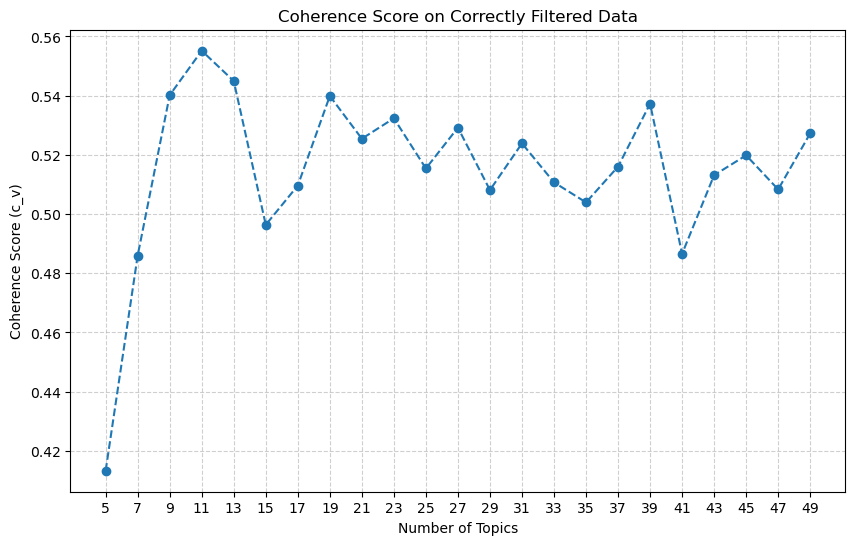


Optimal number of topics is: 11 with a coherence score of 0.5552


In [17]:
# --- Hyperparameter Tuning for Number of Topics ---

# This cell determines the optimal number of topics for the LDA model. It
# defines a function to train multiple models with a varying number of topics,
# calculates a 'c_v' coherence score for each, and then visualizes the results
# to help identify the best-performing model.

#
# --- Step 3: Define the Coherence Calculation Function ---
#
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Trains multiple LDA models and computes their 'c_v' coherence scores.

    This function iterates through a specified range for the number of topics.
    For each value, it trains a new LdaMulticore model and calculates its
    coherence score, which measures the semantic consistency of the topics.

    Args:
        dictionary (gensim.corpora.Dictionary): The Gensim dictionary for the corpus.
        corpus (list): The Gensim bag-of-words corpus.
        texts (list): The original tokenized text, required by the coherence model.
        limit (int): The maximum number of topics to test (exclusive).
        start (int, optional): The starting number of topics. Defaults to 5.
        step (int, optional): The step size for the topic number range. Defaults to 5.

    Returns:
        tuple[list, list]: A tuple containing the list of trained models and
                           the corresponding list of coherence scores.
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"Training model with {num_topics} topics...")
        # Train a parallelized LDA model.
        model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             num_topics=num_topics,
                             random_state=RANDOM_STATE,
                             chunksize=1000,
                             passes=5,
                             workers=6)
        model_list.append(model)
        # Calculate the coherence score for the trained model.
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

#
# --- Step 4: Run the Tuning Process ---
#
# Execute the tuning function using the prepared Gensim dictionary and corpus.
# The 'texts' parameter is passed the original token sample, which is required
# for the c_v coherence calculation.
print("--- Model Tuning ---")
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                      corpus=corpus,
                                                      texts=sample_tokens, 
                                                      start=5,
                                                      limit=50,
                                                      step=2)

#
# --- Step 5: Visualize the Results and Find the Best Score ---
#
# The coherence scores are plotted against the number of topics. This plot
# provides a visual guide to selecting the optimal number of topics, which
# typically corresponds to the highest point on the graph.
print("\n--- Results ---")
limit = 50
start = 5
step = 2
x = range(start, limit, step)
plt.figure(figsize=(10,6))
plt.plot(x, coherence_values, marker='o', linestyle='--')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# This section programmatically identifies the number of topics that yielded
# the highest coherence score and prints the result. It includes a check to
# handle cases where scores might be NaN.
valid_coherence_values = [v for v in coherence_values if not np.isnan(v)]
if valid_coherence_values:
    best_score = max(valid_coherence_values)
    optimal_idx = coherence_values.index(best_score)
    optimal_num_topics = start + (optimal_idx * step)
    print(f"\nOptimal number of topics is: {optimal_num_topics} with a coherence score of {best_score:.4f}")
else:
    print("\nCould not determine an optimal number of topics, all coherence scores were NaN.")

final_num_topics = optimal_num_topics

In [ ]:
# --- Fine-Tuning Alpha and Eta Hyperparameters ---

# This cell performs a grid search to find the optimal 'alpha' and 'eta'
# hyperparameters for the LDA model. The number of topics is held constant at
# the optimal value determined in the previous cell. The goal is to find the
# combination of these two priors that produces the highest topic coherence.

import numpy as np
from gensim.models import LdaMulticore, CoherenceModel, LdaModel

#
# --- Step 1: Define the Hyperparameter Search Space ---
#
# A list of options is defined for both alpha and eta. Alpha is the document-
# topic prior, controlling the sparsity of topic distributions for each
# document. Eta is the topic-word prior, controlling the sparsity of word
# distributions for each topic. The options include numeric values as well as
# special strings recognized by Gensim ('auto', 'symmetric', etc.).
alpha_options = [0.01, 0.1, 1, 'asymmetric', 'auto']
eta_options = [0.01, 0.1, 1, 'symmetric', 'auto']

#
# --- Step 2: Run the Fine-Tuning Loop ---
#
# A nested loop iterates through every possible combination of the defined
# alpha and eta values. For each pair, an LDA model is trained and its
# coherence score is calculated and stored.
tuning_results = []
print(f"--- Fine-Tuning Priors for {optimal_num_topics} Topics ---")

for alpha in alpha_options:
    for eta in eta_options:
        # Gensim requires that if the eta prior is 'symmetric', the alpha prior
        # cannot be 'asymmetric'. This check skips this invalid combination.
        if alpha == 'asymmetric' and eta == 'symmetric':
            continue

        print(f"Testing with alpha='{alpha}' and eta='{eta}'...")

        # Train the LDA model with the current set of hyperparameters.
        model = LdaModel(corpus=corpus,
                       id2word=id2word,
                       num_topics=optimal_num_topics,
                       random_state=RANDOM_STATE,
                       alpha=alpha,
                       eta=eta,
                       passes=5)

        # Calculate and store the coherence score.
        coherencemodel = CoherenceModel(model=model, texts=sample_tokens, dictionary=id2word, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()

        tuning_results.append({
            'alpha': alpha,
            'eta': eta,
            'coherence': coherence_score
        })



In [25]:
#
# --- Step 3: Find and Display the Best Combination ---
#
# After the grid search is complete, this section identifies the combination
# of hyperparameters that resulted in the highest coherence score. A full
# summary of all tested combinations is printed, followed by the single
# best result.
best_result = max(tuning_results, key=lambda x: x['coherence'])

print("\n--- Hyperparameter Tuning Complete ---")
for result in tuning_results:
    print(f"Alpha: {result['alpha']}, Eta: {result['eta']}, Coherence: {result['coherence']:.4f}")

print("\n--- Best Result ---")
print(f"Optimal Alpha: {best_result['alpha']}")
print(f"Optimal Eta: {best_result['eta']}")
print(f"Best Coherence Score: {best_result['coherence']:.4f}")


--- Hyperparameter Tuning Complete ---

--- Best Result ---
Optimal Alpha: asymmetric
Optimal Eta: 1
Best Coherence Score: 0.5704


### 4.1.1. Baseline Coherence Score (Naive Preprocessing)
To prove the value of our feature engineering, we first need a baseline. This cell calculates the best possible coherence score on the raw command-line data with only the most basic tokenization (splitting by spaces). This score will serve as the benchmark to measure our improvements against.

In [ ]:
# --- Baseline Model Data Preparation ---

# This cell prepares a "baseline" dataset for performance comparison. It
# intentionally uses a very simplistic preprocessing method—a basic whitespace
# split on the raw command line—to establish a benchmark coherence score.
# This baseline will be used to demonstrate the value of the more sophisticated
# normalization and tokenization techniques used in the main analysis.

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt
import random

#
# --- Step 1: Create Naive Tokens ---
#
# Instead of using the advanced tokenizer, a "naive" token list is created
# for each command by simply splitting the raw string by spaces. This mimics a
# basic, unprocessed approach to topic modeling.
naive_tokens = [str(cmd).split() for cmd in data['command_line'].tolist()]

#
# --- Step 2: Prepare Naive Data for Gensim ---
#
# For efficiency and a fair comparison, a sample of the naive tokens is taken,
# mirroring the process used for the main dataset. This sample is then
# converted into Gensim's required Dictionary and Corpus formats.
if len(naive_tokens) > 100000:
    # A fixed random state ensures the sample is reproducible.
    random.seed(RANDOM_STATE)
    sample_naive_tokens = random.sample(naive_tokens, 100000)
else:
    sample_naive_tokens = naive_tokens

id2word_naive = Dictionary(sample_naive_tokens)
corpus_naive = [id2word_naive.doc2bow(token_list) for token_list in sample_naive_tokens]
print(f"Gensim dictionary and corpus for baseline created from a sample of {len(sample_naive_tokens)} documents.")

In [ ]:
# --- Baseline Model Coherence Calculation ---

# This cell trains a series of LDA models using the naively preprocessed data.
# It reuses the same coherence calculation function from the main analysis to
# ensure a fair, apples-to-apples comparison between the baseline and the
# advanced preprocessing methods.

def compute_coherence_values(dictionary: Dictionary, corpus: list, texts: list, limit: int, start: int = 5, step: int = 5) -> list:
    """
    Trains multiple LDA models and computes their 'c_v' coherence scores.

    This function iterates through a specified range for the number of topics.
    For each value, it trains a new LdaMulticore model and calculates its
    coherence score, which measures the semantic consistency of the topics.

    Args:
        dictionary (Dictionary): The Gensim dictionary for the corpus.
        corpus (list): The Gensim bag-of-words corpus.
        texts (list): The original tokenized text, required by the coherence model.
        limit (int): The maximum number of topics to test (exclusive).
        start (int, optional): The starting number of topics. Defaults to 5.
        step (int, optional): The step size for the topic number range. Defaults to 5.

    Returns:
        list: A list containing the coherence score for each tested number of topics.
    """
    coherence_values = []
    for num_topics in range(start, limit, step):
        print(f"Training baseline model with {num_topics} topics...")
        model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             random_state=RANDOM_STATE,
                             workers=4)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values

#
# --- Execute Coherence Calculation on Baseline Data ---
#
# The tuning function is called with the naive dictionary, corpus, and tokens
# to generate the coherence scores for the baseline models.
baseline_coherence_values = compute_coherence_values(dictionary=id2word_naive, corpus=corpus_naive, texts=sample_naive_tokens, start=5, limit=50, step=5)

Gensim dictionary and corpus for baseline created from a sample of 100000 documents.
Training baseline model with 5 topics...
Training baseline model with 10 topics...
Training baseline model with 15 topics...
Training baseline model with 20 topics...
Training baseline model with 25 topics...
Training baseline model with 30 topics...
Training baseline model with 35 topics...
Training baseline model with 40 topics...
Training baseline model with 45 topics...


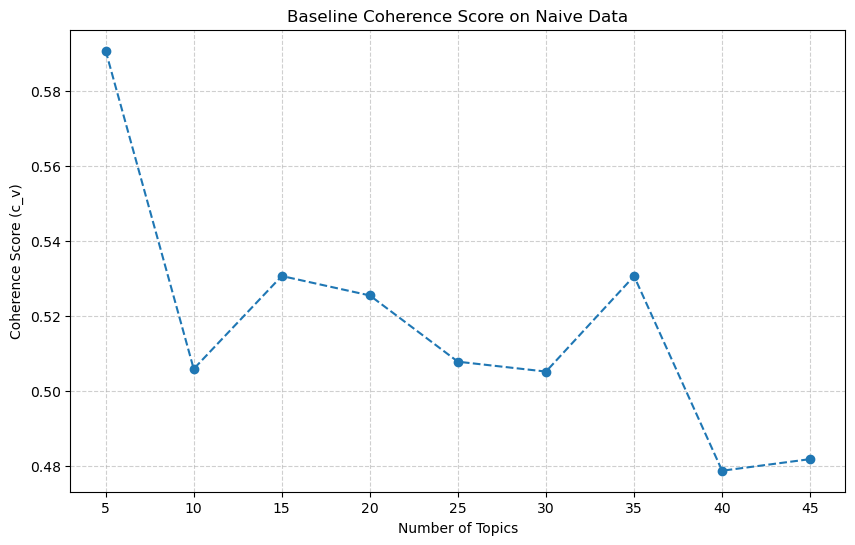


--- Baseline Results ---
The HIGHEST coherence score achievable with naive preprocessing is: 0.5907
This was achieved with 5 topics.
This score is the benchmark we need to beat.


In [27]:
# --- Baseline Results Visualization and Analysis ---

# This cell visualizes the coherence scores for the baseline models and
# programmatically identifies the peak score. This maximum score serves as the
# official benchmark that the advanced preprocessing pipeline must exceed to
# be considered effective.

#
# --- Step 4: Visualize and Find the Optimal Baseline Score ---
#
# The results are plotted to provide a clear visual representation of the
# baseline model's performance across the different numbers of topics.
limit = 50
start = 5
step = 5
x = range(start, limit, step)
plt.figure(figsize=(10,6))
plt.plot(x, baseline_coherence_values, marker='o', linestyle='--')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Baseline Coherence Score on Naive Data")
plt.xticks(x)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#
# --- Identify and Display the Best Baseline Score ---
#
# This section programmatically finds the highest coherence score achieved with
# the naive preprocessing and prints it. This value is the target to beat.
best_baseline_score = max(baseline_coherence_values)
optimal_baseline_topics = start + (baseline_coherence_values.index(best_baseline_score) * step)

print(f"\n--- Baseline Results ---")
print(f"The HIGHEST coherence score achievable with naive preprocessing is: {best_baseline_score:.4f}")
print(f"This was achieved with {optimal_baseline_topics} topics.")
print("This score is the benchmark we need to beat.")

### 4.2. Model Training
Train the LDA model with the best parameters found during tuning.

In [15]:
# --- Final Model Configuration and Data Preparation ---

# This cell sets the chosen hyperparameters for the final production model and
# prepares the full, unsampled dataset for training. Unlike the tuning steps
# that used a smaller sample for speed, the final model is trained on all
# available data to maximize its learning potential.

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, LdaModel
import matplotlib.pyplot as plt
import random

#
# --- Set Final Hyperparameters ---
#
# These parameters are used to configure the final LDA model. The number of
# topics is taken from the previous tuning experiments, while alpha and eta
# are manually set to symmetric priors.
# OPTIMAL_NUM_TOPICS = final_num_topics
# OPTIMAL_ALPHA = best_result['alpha'] 
# OPTIMAL_ETA = best_result['eta']
OPTIMAL_NUM_TOPICS = 11
OPTIMAL_ALPHA =  'asymmetric'
OPTIMAL_ETA = 1


#
# --- Prepare the Full Dataset for Gensim ---
#
# The Gensim Dictionary and Corpus are recreated here using the entire,
# properly tokenized dataset ('data['tokens']'). This ensures the final
# model is trained on all available, high-quality data.
final_id2word = Dictionary(data['tokens'])
final_tokens = data['tokens'].tolist()
final_corpus = [final_id2word.doc2bow(token_list) for token_list in final_tokens]

In [ ]:
# --- Final Model Training ---

# This cell trains the final, production-ready LdaMulticore model using the
# full dataset and the hyperparameters defined in the previous cell. The model
# is configured to use multiple CPU cores to accelerate the training process.

import logging
import os

# The following line can be uncommented to enable detailed logging from the
# Gensim library, which shows progress during model training.
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#
# --- Configure Parallel Processing ---
#
# To train efficiently, the number of worker processes is set dynamically based
# on the number of available CPU cores. One core is typically left free for the
# operating system and other background tasks.
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")
workers = num_cores - 1 if num_cores > 1 else 1

#
# --- Instantiate and Train the LdaMulticore Model ---
#
# The LdaMulticore model is used for its ability to perform parallelized
# training. It is initialized with the full corpus, the final dictionary, and
# the chosen hyperparameters. A higher number of passes is used to ensure the
# model converges thoroughly on the full dataset.
lda_model = LdaMulticore(
    corpus=final_corpus,
    id2word=final_id2word,
    num_topics=OPTIMAL_NUM_TOPICS,
    alpha=OPTIMAL_ALPHA,
    eta=OPTIMAL_ETA,
    random_state=RANDOM_STATE,
    passes=10,
    chunksize=20000,
    workers=workers
)

Number of CPU cores: 48


### 4.3. Save and Load Model

In [7]:
# --- Model Persistence: Saving and Loading ---

# This cell contains the code for saving the final trained LDA model to disk
# and for loading it back into memory. Persisting the model is a crucial step
# as it allows the trained state to be reused in future sessions without
# needing to re-run the entire time-consuming training pipeline.
#
# Note: The code in this cell is currently commented out. Uncomment the
# desired section to save or load the model.

#
# --- Save the Trained Model ---
#
# The `joblib.dump` function is used to serialize the `lda_model` object and
# write it to a file. This process captures all the learned parameters and
# the complete state of the model, creating a reusable artifact.
# joblib.dump(lda_model, MODEL_FILENAME)
# print(f"Model saved to {MODEL_FILENAME}")

#
# --- Load the Model ---
#
# The `joblib.load` function deserializes the model from the specified file,
# restoring it to memory. This allows you to immediately use the pre-trained
# model in a new notebook or application for analysis or inference.
# lda_model = joblib.load(MODEL_FILENAME)
# print("Model loaded successfully.")

Model loaded successfully.


--- 
## 5. Results and Visualization

### 5.1. Topic Assignment and DataFrame Creation
Assign the most likely topic to each command and save the results to a Parquet file for further analysis.

In [12]:
# --- Final Analysis: Topic Assignment and Data Export ---

# This is the final step of the analysis pipeline. This cell uses the fully
# trained LDA model to assign a topic to each command line in the complete
# dataset. The resulting DataFrame, now enriched with topic assignments and
# all previously engineered features, is then saved to a file for future
# exploration, visualization, or reporting.

#
# --- Assign Topics to the Full Dataset ---
#
# The `get_topic_results_gensim` helper function processes the entire corpus
# with the final model. It determines the most likely topic for each document
# and adds this information as a new 'topic' column to the DataFrame.
df_with_topics = get_topic_results_gensim(lda_model, final_corpus, data)

#
# --- Save the Final Analysis DataFrame ---
#
# The enriched DataFrame is saved using the Parquet file format. Parquet is a
# columnar storage format that is highly efficient for both storage space and
# analytical query performance, making it well-suited for large datasets.
df_with_topics.to_parquet(ANALYSIS_DATAFRAME_FILENAME)
print(f"DataFrame with topics saved to {ANALYSIS_DATAFRAME_FILENAME}")


Step 3: Displaying topics and assigning to DataFrame...
Top words for each topic:
Topic #0: 0.017*"/subcategory" + 0.016*"<guid>" + 0.016*"/get" + 0.016*"/r" + 0.014*"0"
Topic #1: 0.017*"microsoft" + 0.015*"c:\program files " + 0.014*"x86" + 0.012*"/prefetch" + 0.012*"application"
Topic #2: 0.074*"c:\windows\temp\securitypolicy.inf " + 0.071*"/export" + 0.069*"c:\windows\system32\secedit.exe " + 0.069*"/cfg" + 0.068*"/areas"
Topic #3: 0.027*"0" + 0.017*"-object" + 0.015*"<guid>" + 0.015*"<long_number>" + 0.014*"select"
Topic #4: 0.030*"/r" + 0.028*"/get" + 0.027*"/subcategory" + 0.023*"auditpol.exe" + 0.021*"<guid>"
Topic #5: 0.018*"/cfg" + 0.018*"/areas" + 0.017*"c:\windows\system32\secedit.exe " + 0.017*"/export" + 0.017*"user_rights"
Topic #6: 0.021*"/subcategory" + 0.019*"/get" + 0.018*"/c" + 0.017*"/r" + 0.016*"<guid>"
Topic #7: 0.023*"/get" + 0.020*"/subcategory" + 0.020*"/r" + 0.019*"<guid>" + 0.017*"auditpol.exe"
Topic #8: 0.026*"/r" + 0.024*"/subcategory" + 0.023*"/get" + 0.0

### 5.2. Treemap of Topics

In [13]:
# --- Final Visualization: Topic Treemap ---

# This cell generates the final output of the analysis: an interactive treemap
# that visualizes the composition of the discovered topics. This visualization
# provides a clear, hierarchical view of the command groups within each topic,
# making the model's results easy to interpret.

#
# --- Load Analysis DataFrame (Optional) ---
#
# The following line can be uncommented to load the analysis results directly
# from the saved Parquet file. This is useful for quickly regenerating the
# visualization in a new session without re-running the entire notebook.
#df_with_topics = pd.read_parquet(ANALYSIS_DATAFRAME_FILENAME)

#
# --- Create and Display the Treemap ---
#
# The `create_topic_treemap_gensim` helper function is called to generate the
# final visualization. It processes the DataFrame with topic assignments and
# the trained model to create an interactive treemap where the top-level
# rectangles are topics and the nested rectangles represent command groups.
# The size of each rectangle corresponds to the frequency of that command group.
create_topic_treemap_gensim(df_with_topics, lda_model)

--- Preparing data and generating treemap for gensim model ---
Grouping similar commands using fuzzy matching...
Grouping complete.


### 5.3. Identify LOLBAS Heavy Topics

The density of LOLBAS commands in each topic is not indicative of the topic being a "malicious" topic. These commands are just goalposts for you to pivot off of within the topic to compare the known-malicious commands with the unlabeled commands.

In [14]:
# --- Analysis of LOLBAS Command Distribution ---

# This cell analyzes how the known LOLBAS (Living Off The Land Binaries and
# Scripts) commands, which were added to the dataset earlier, have been
# distributed across the topics generated by the final LDA model.

# Load the necessary LOLBAS data from the local repository.
lolbas_repo_path = './OSBinaries'
lolbas_keywords = generate_keywords_from_lolbas(lolbas_repo_path)
all_lolbas_commands = get_all_lolbas_commands(lolbas_repo_path)

def count_lolbas_commands_per_topic(df_with_topics: pd.DataFrame, lolbas_commands_list: list) -> pd.Series:
    """
    Finds LOLBAS commands in a DataFrame and counts their distribution per topic.

    This function filters the input DataFrame to isolate only the rows that
    correspond to known LOLBAS commands. It then performs a value count to
    determine how many of these commands were assigned to each topic by the
    LDA model.

    Args:
        df_with_topics (pd.DataFrame): The DataFrame containing analysis results,
            including a 'command_line' and a 'topic' column.
        lolbas_commands_list (list): A list of known LOLBAS command strings.

    Returns:
        pd.Series: A pandas Series with topic IDs as the index and the count of
                   LOLBAS commands per topic as values, sorted descending.
                   Returns an empty Series if no LOLBAS commands are found.
    """
    print("--- Counting LOLBAS Command Assignments Per Topic ---")

    # To ensure a robust, case-insensitive comparison, both the command lines
    # in the DataFrame and the reference list of LOLBAS commands are
    # converted to lowercase and stripped of leading/trailing whitespace.
    df_commands_cleaned = df_with_topics['command_line'].str.strip().str.lower()
    lolbas_commands_cleaned = {cmd.strip().lower() for cmd in lolbas_commands_list}

    # The DataFrame is filtered using `isin` to efficiently select only the
    # rows where the command line is present in the cleaned set of LOLBAS commands.
    lolbas_df = df_with_topics[df_commands_cleaned.isin(lolbas_commands_cleaned)]

    if lolbas_df.empty:
        print("No LOLBAS commands were found in the provided DataFrame.")
        return pd.Series()

    # A value count is performed on the 'topic' column of the filtered
    # DataFrame to get the total count of LOLBAS commands assigned to each topic.
    topic_counts = lolbas_df['topic'].value_counts()

    print("LOLBAS Command Count Per Topic (Descending):")
    print(topic_counts.to_string())

    return topic_counts

# Execute the function to count and display the distribution of LOLBAS commands.
lolbas_topic_counts = count_lolbas_commands_per_topic(df_with_topics, all_lolbas_commands)

--- Counting LOLBAS Command Assignments Per Topic ---
LOLBAS Command Count Per Topic (Descending):
topic
5     145
0      37
14     24
6      12
1      12
12      5
8       4
13      4
3       3
9       2
2       1
7       1
4       1


### 5.3. Interactive Topic Explorer

In [18]:
# --- Interactive Topic Explorer Widget ---

# This cell creates an interactive dashboard for exploring the results
# of the topic model. It uses the ipywidgets library to build a user interface
# that allows for dynamic filtering of the data by topic and by a text search.
# The output updates in real-time to show topic keywords, a plot of the most
# common executables, and the raw command lines that match the filters.

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import plotly.express as px

def sanitize_for_latex_display(text: str) -> str:
    """
    Escapes characters that could trigger LaTeX rendering in Jupyter displays.

    In Jupyter and IPython environments, text containing dollar signs ($) can
    be misinterpreted as a LaTeX mathematical expression, causing rendering
    issues. This utility function replaces any '$' with an escaped '\$' to
    ensure the text is displayed as a literal string.

    Args:
        text (str): The input string to sanitize.

    Returns:
        str: The sanitized string with dollar signs escaped. Returns the
             original input if it is not a string.
    """
    if not isinstance(text, str):
        return text
    # Replace the dollar sign with an escaped dollar sign for safe display.
    return text.replace('$', r'\$')

def create_explorer_with_observers(df_with_topics: pd.DataFrame, lda_model, vectorizer):
    """
    Creates and displays an interactive topic explorer widget.

    This function builds a user interface with a dropdown for topic selection
    and a text box for searching. It uses the explicit observer pattern from
    ipywidgets for robust, event-driven updates. When a user changes a selection,
    the widget updates to show the top keywords for the topic, a bar chart of
    the most frequent executables, and a table of matching command lines.

    Args:
        df_with_topics (pd.DataFrame): The DataFrame with topic assignments.
        lda_model (gensim.models.LdaMulticore): The trained Gensim LDA model.
        vectorizer (sklearn.feature_extraction.text.TfidfVectorizer): The
            fitted vectorizer object.

    Returns:
        None: This function's side effect is to display the widget in the
              Jupyter environment.
    """
    topic_options = sorted(df_with_topics['topic'].unique())
    feature_names = vectorizer.get_feature_names_out()

    # --- 1. Create the User Interface Widgets ---
    #
    # The necessary input controls and the output area are instantiated. The
    # Output widget will serve as the container for all dynamically generated content.
    topic_dropdown = widgets.Dropdown(options=topic_options, description='Select Topic:')
    search_box = widgets.Text(value='', placeholder='Search commands, paths, etc...', description='Search:')
    output_widget = widgets.Output()

    # --- 2. Define a Master Function to Update the View ---
    #
    # This function contains all the logic for filtering the data and
    # rendering the results. It is designed to be called whenever one of the
    # input widgets changes its value.
    def update_view(change):
        # Read the current values directly from the widgets.
        selected_topic = topic_dropdown.value
        search_term = search_box.value

        # The 'with output_widget' context manager directs all subsequent
        # display calls into the widget. `clear_output` prevents results
        # from stacking up on each update.
        with output_widget:
            clear_output(wait=True)

            # Filter the DataFrame based on the selected topic.
            topic_df = df_with_topics[df_with_topics['topic'] == selected_topic].copy()
            
            # If a search term is provided, apply a second-level filter across
            # multiple relevant columns for a comprehensive search.
            if search_term:
                mask = (
                    topic_df['command_line'].str.contains(search_term, case=False, regex=True) |
                    topic_df['normalized_command'].str.contains(search_term, case=False, regex=True) |
                    topic_df['root_command'].str.contains(search_term, case=False, regex=True)
                )
                topic_df = topic_df[mask]

            if topic_df.empty:
                print(f"No matching data found.")
                return

            # Display the top keywords that define the selected topic.
            topic_dist = lda_model.show_topic(selected_topic, topn=10)
            top_words = [word for word, prob in topic_dist]
            print(f"--- Exploring Topic {selected_topic} ({len(topic_df)} matching commands) ---")
            print(f"Top Keywords: {' '.join(top_words)}")
            
            # Generate and display a bar chart of the most frequent executables
            # found within the filtered data.
            top_roots = topic_df['root_command'].value_counts().nlargest(15).sort_values()
            fig = px.bar(top_roots, x=top_roots.values, y=top_roots.index, orientation='h',
                         title=f'Top Executables', labels={'x': 'Count', 'y': 'Executable'}, height=400)
            fig.show()

            # Display a sanitized, scrollable table of the matching raw command lines.
            print("\nMatching Commands:")
            df_display = topic_df[['command_line']].copy()
            df_display['command_line'] = df_display['command_line'].apply(sanitize_for_latex_display)
            display(df_display)

    # --- 3. Attach the Update Function as an Observer ---
    #
    # The `observe` method links the `update_view` function to the 'value'
    # property of the input widgets. Now, any change to the dropdown or search
    # box will automatically trigger the `update_view` function.
    topic_dropdown.observe(update_view, names='value')
    search_box.observe(update_view, names='value')

    # --- 4. Display the Widget Layout and Trigger the Initial View ---
    #
    # The controls are arranged vertically, and the final layout is displayed.
    # The `update_view` function is called once manually to populate the
    # output with the initial state when the widget is first rendered.
    controls = widgets.VBox([topic_dropdown, search_box])
    display(controls, output_widget)
    
    update_view(None)
    
# Call the main function to build and render the interactive explorer.
create_explorer_with_observers(df_with_topics, lda_model, vectorizer)

Output()

--- 
## 6. Conclusion
This notebook successfully processed a large dataset of command-line logs, applied NLP techniques to extract meaningful features, and used topic modeling to uncover hidden patterns. The visualizations provide an intuitive way to explore the identified command clusters.

**Potential Next Steps:**
* Analyze the distribution of topics over time to identify trends.
* Investigate rare or anomalous commands that do not fit well into any topic.
* Use the trained model to classify new, unseen command-line data in real-time.